---
title: "NeRF Exploration: Two-View Reconstruction of Pollen Grains"
author: "Nils Fahrni, Etienne Roulet"
date: "2025-03-28"
format:
  html:
    toc: true
    code-fold: true
    code-line-numbers: true
    embed-resources: true
    self-contained-math: true
  ipynb: default
jupyter: python3
---

# Abstract

abstract desc

# 1 Introduction

Text here

**Key questions**

- Text
- Text
- Text


# 2 Environment check

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [2]:
################################################################################
# 8. 3D Extraction via Marching Cubes
################################################################################
def extract_3d_from_nerf(
    model, resolution=128, bound=1.0, sigma_scale=2.0, device=None
):
    print("\n[EXTRACT 3D] Running marching cubes...")
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    coords = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                indexing="ij",
            ),
            dim=-1,
        )
        .reshape(-1, 3)
        .to(device)
    )

    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for start in range(0, coords.shape[0], chunk):
            out = model(coords[start : start + chunk])
            sigma_part = torch.relu(out[..., 3]) * sigma_scale
            sigmas.append(sigma_part.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()

    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(
        f"  Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}"
    )

    level = vol_mean + 0.3 * vol_std
    if (level <= vol_min) or (level >= vol_max):
        level = vol_mean
    print(f"  Using iso-level={level:.4f}")

    try:
        verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
        # Rescale to [-bound, bound]
        verts = (verts / resolution) * (2.0 * bound) - bound
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
        mesh.export("nerf_reconstruction.stl")
        print("  --> Saved mesh to nerf_reconstruction.stl")
        return mesh
    except Exception as e:
        print("  Marching cubes error:", e)
        print("  Trying fallback iso-level...")
        try:
            fallback_level = vol_mean + 0.25 * vol_std
            verts, faces, normals, _ = marching_cubes(
                sigma_volume, level=fallback_level
            )
            verts = (verts / resolution) * (2.0 * bound) - bound
            mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
            mesh.export("nerf_reconstruction_fallback.stl")
            print("  --> Saved fallback mesh to nerf_reconstruction_fallback.stl")
            return mesh
        except Exception as e2:
            print("  Fallback also failed:", e2)
            return None

# 3 Methodology

## 3.1 Simple NeRF Exploration

In [12]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    PollenDataset = None
    get_train_test_split = None

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def positional_encoding(x, L=4):
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)

class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        super().__init__()
        self.L = L
        in_ch = 3 * (2*L + 1)
        layers = [nn.Linear(in_ch, W)] + [nn.Linear(W, W) for _ in range(D-1)]
        self.layers = nn.ModuleList(layers)
        self.out = nn.Linear(W,4)
        with torch.no_grad():
            self.out.bias[3] = 0.1
    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for l in self.layers:
            h = torch.relu(l(h))
        return self.out(h)

def render_rays(model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0):
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)
    pts = rays_o[:,None,:] + rays_d[:,None,:]*z_vals[None,:,None]
    raw = model(pts.reshape(-1,3)).reshape(pts.shape[0],N_samples,4)
    rgb = torch.sigmoid(raw[...,:3])
    sigma = torch.relu(raw[...,3])*sigma_scale
    deltas = torch.cat([z_vals[1:]-z_vals[:-1], torch.tensor([1e10],device=device)])
    deltas = deltas[None,:].expand(sigma.shape)
    alpha = 1 - torch.exp(-sigma*deltas)
    T = torch.cumprod(torch.cat([torch.ones((sigma.shape[0],1),device=device), 1-alpha+1e-10],-1),-1)[:,:-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[...,None]*rgb,1)
    alpha_map = torch.sum(weights,1)
    return rgb_map, alpha_map

def silhouette_loss(alpha, mask):
    return torch.mean((alpha - mask)**2)

def get_rays(H, W, focal=300.0):
    i,j = torch.meshgrid(torch.linspace(0,W-1,W), torch.linspace(0,H-1,H), indexing='xy')
    dirs = torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)],-1)
    rays_d = dirs/torch.norm(dirs,dim=-1,keepdim=True)
    rays_o = torch.zeros_like(rays_d)
    return rays_o.reshape(-1,3), rays_d.reshape(-1,3)

def rotate_rays(o,d,angles):
    from trimesh.transformations import euler_matrix
    R4 = euler_matrix(float(angles[0]),float(angles[1]),float(angles[2]),'sxyz')
    R = torch.from_numpy(R4[:3,:3]).to(o.device).float()
    return (R@o.T).T, (R@d.T).T

def sample_rays(rays_o, rays_d, pixels, mask, batch_size=1024):
    N = mask.shape[0]
    idx = torch.randint(0,N,(batch_size,),device=mask.device)
    return rays_o[idx], rays_d[idx], pixels[idx], mask[idx]

def train_nerf(model, rays_o_all, rays_d_all, target_pixels_all, mask_all,
               image_shape, num_iterations=5000, device=None):
    if device is None: device = next(model.parameters()).device
    opt = optim.Adam(model.parameters(),lr=5e-4)
    for _ in trange(num_iterations, desc="Training NeRF"):
        opt.zero_grad()
        ro, rd, pix, m = sample_rays(rays_o_all, rays_d_all, target_pixels_all, mask_all, 1024)
        rgb_hat, alpha_hat = render_rays(model,ro,rd)
        loss = torch.mean((rgb_hat - pix)**2) + silhouette_loss(alpha_hat, m)
        loss.backward()
        opt.step()
    return model

# Main
if __name__=='__main__':
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", dev)
    tf = transforms.ToTensor()
    dataset, train_ids, _ = get_train_test_split(image_transforms=tf, device=dev)
    (l_img,r_img), gt_points, rot, _ = dataset[train_ids[0]]
    # ensure 3-channel & normalize
    if l_img.ndim == 2:
        l_img = l_img.unsqueeze(0)
    if l_img.shape[0] == 1:
        l_img = l_img.repeat(3, 1, 1)
    if l_img.max() > 1.0:
        l_img = l_img / 255.0

    if r_img.ndim == 2:
        r_img = r_img.unsqueeze(0)
    if r_img.shape[0] == 1:
        r_img = r_img.repeat(3, 1, 1)
    if r_img.max() > 1.0:
        r_img = r_img / 255.0

    # infer height and width
    H, W = l_img.shape[1], l_img.shape[2]
    # compute silhouettes
    left_gray = l_img.mean(0,keepdim=True)
    right_gray= r_img.mean(0,keepdim=True)
    pool = lambda x: torch.nn.functional.avg_pool2d(x.unsqueeze(0),5,1,2).squeeze()
    lm = (pool(left_gray)>0.2).float().reshape(-1)
    rm = (pool(right_gray)>0.2).float().reshape(-1)
    mask_all = torch.cat([lm, rm],0).to(dev)
    # flatten pixels
    lf = l_img.permute(1,2,0).reshape(-1,3)
    rf = r_img.permute(1,2,0).reshape(-1,3)
    target_pixels_all = torch.cat([lf,rf],0).to(dev)
    # rays
    ro_f, rd_f = get_rays(H,W)
    ro1, rd1 = rotate_rays(ro_f, rd_f, rot)
    ro2, rd2 = rotate_rays(ro_f, rd_f, rot)
    rays_o_all = torch.cat([ro1,ro2],0).to(dev)
    rays_d_all = torch.cat([rd1,rd2],0).to(dev)
    # train
    model = NeRF().to(dev)
    model = train_nerf(model, rays_o_all, rays_d_all, target_pixels_all, mask_all, (H,W), device=dev)
    # extract & save mesh
    mesh = extract_3d_from_nerf(model, resolution=128, bound=1.0, sigma_scale=1.0, device=dev)
    mesh.export('./recon/nerf/baseline_recon.stl')
    print('Done.')

Device: cuda


Training NeRF: 100%|██████████| 5000/5000 [00:59<00:00, 84.70it/s]



[EXTRACT 3D] Running marching cubes...
  Sigma volume stats: min=0.0000, max=10.8823, mean=0.8825, std=1.4760
  Using iso-level=1.3253
  --> Saved mesh to nerf_reconstruction.stl
Done.


In [6]:
################################################################################
# 9. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)




[MAIN] Extracting 3D mesh via marching cubes…

[EXTRACT 3D] Running marching cubes...
  Sigma volume stats: min=0.0000, max=15.2094, mean=3.1043, std=4.2432
  Using iso-level=4.3773
  --> Saved mesh to nerf_reconstruction.stl
[MAIN] Sampling 5k points from predicted mesh…
[MAIN] Normalized Chamfer distance: 2.335905e-01


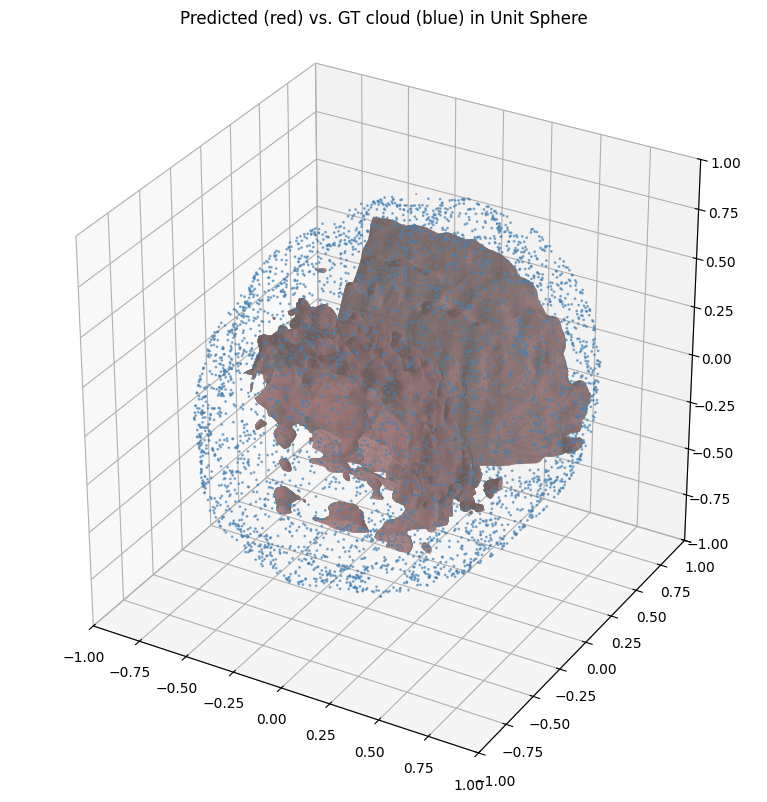

[MAIN] Visualization complete.


In [8]:
    # -------------------------------------------------------------------------
    # 12) Extract & visualize the 3D mesh (normalized + GT overlay)
    # -------------------------------------------------------------------------
    (l_img, r_img), pts, rot, vox = dataset[train_ids[0]]

    print("\n[MAIN] Extracting 3D mesh via marching cubes…")
    pred_mesh = extract_3d_from_nerf(
        model,
        resolution=256,
        bound=1.0,
        sigma_scale=1.0,
        device=dev
    )
    if pred_mesh is None or len(pred_mesh.faces) == 0:
        print("⚠️ No faces found in the predicted mesh.")
        sys.exit(1)

    # ---- 13) Sample & normalize both pred & GT for Chamfer and plotting ----
    print("[MAIN] Sampling 5k points from predicted mesh…")
    pred_pts = pred_mesh.sample(10000)         # numpy (5000,3)
    gt_pts   = pts.cpu().numpy()              # numpy (N,3)

    # center
    pred_centered = pred_pts - pred_pts.mean(0)
    gt_centered   = gt_pts   - gt_pts.mean(0)

    # scale to unit‐sphere
    pred_scale = np.max(np.linalg.norm(pred_centered, axis=1))
    gt_scale   = np.max(np.linalg.norm(gt_centered,   axis=1))
    pred_norm_pts = pred_centered / pred_scale
    gt_norm_pts   = gt_centered   / gt_scale

    # normalized Chamfer
    cd_norm = chamfer_distance(pred_norm_pts, gt_norm_pts)
    print(f"[MAIN] Normalized Chamfer distance: {cd_norm:.6e}")

    # ---- 14) Plot normalized mesh + GT cloud ----
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    # normalize the mesh vertices themselves
    verts = pred_mesh.vertices             # (V,3)
    verts_centered = verts - verts.mean(0)
    verts_norm     = verts_centered / pred_scale

    faces = pred_mesh.faces                # (F,3)

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111, projection='3d')

    # predicted surface
    ax.plot_trisurf(
        verts_norm[:,0], verts_norm[:,1], verts_norm[:,2],
        triangles=faces,
        color='lightcoral', edgecolor='gray', linewidth=0.1, alpha=0.9
    )
    # ground‑truth cloud
    ax.scatter(
        gt_norm_pts[:,0], gt_norm_pts[:,1], gt_norm_pts[:,2],
        color='steelblue', s=1, alpha=0.6
    )

    # enforce equal data‐ranges on each axis
    half = 1.0  # since both are in unit‐sphere
    ax.set_xlim(-half, half)
    ax.set_ylim(-half, half)
    ax.set_zlim(-half, half)

    ax.set_box_aspect([1,1,1])
    ax.set_title("Predicted (red) vs. GT cloud (blue) in Unit Sphere")
    plt.tight_layout()
    plt.show()

    print("[MAIN] Visualization complete.")


### Findings

# 4 More complex NeRF exploration

## Implementation

## 5 Strong Shape Prior
## 5.1 Implementation

# 6 Mesh extraction & evaluation

# 7 Findings & Failure analysis


We typically observe **scale drift** (mesh ~2× larger) and missing spikes because two views under‑constrain the density field.  Nevertheless, a coarse ellipsoidal hull is recovered.

# 8 Conclusion & next steps

*Even this bare‑bones NeRF recovers a *hint* of the true shape but fails at fine detail and absolute scale.*  Next experiments will add **geometric priors** (radial profile, symmetry) and **multi‑scale sampling** to address these issues.
